# Intro to Non-Gaussian Sources and Joint Distributions

This script surveys several 1D non-Gaussian sources and shows how they combine
into independent vs dependent joint distributions. We contrast linear mixing
(ICA-style) with probabilistic mixture models so students see how different
generative assumptions produce very different point clouds.

In [1]:
import os
from typing import Callable, Dict

import matplotlib.pyplot as plt
import numpy as np

TOPIC = "intro_distributions"
FIG_DIR = os.path.join("figures", TOPIC)
os.makedirs(FIG_DIR, exist_ok=True)

rng = np.random.default_rng(42)

## Helper distributions

We implement a handful of source samplers to showcase heavy tails, sparsity,
and multimodality—common ingredients for ICA-friendly signals.

In [2]:
def sample_laplace(size: int) -> np.ndarray:
    return rng.laplace(loc=0.0, scale=1 / np.sqrt(2), size=size)


def sample_uniform(size: int) -> np.ndarray:
    return rng.uniform(-1.0, 1.0, size=size)


def sample_bimodal(size: int) -> np.ndarray:
    mix = rng.choice([-2.0, 2.0], size=size)
    noise = rng.normal(0.0, 0.4, size=size)
    return mix + noise


def sample_logistic(size: int) -> np.ndarray:
    return rng.logistic(loc=0.0, scale=1.0, size=size)


def sample_sparse_laplace(size: int) -> np.ndarray:
    mask = rng.random(size) < 0.8
    spikes = rng.laplace(loc=0.0, scale=0.3, size=size)
    spikes[mask] = 0.0
    return spikes


def sample_beta_rescaled(size: int) -> np.ndarray:
    raw = rng.beta(0.5, 0.5, size=size)
    return 2 * raw - 1


def sample_student_t(size: int, df: float = 2.5) -> np.ndarray:
    return rng.standard_t(df, size=size)


def sample_lognormal_centered(size: int) -> np.ndarray:
    raw = rng.lognormal(mean=0.0, sigma=0.5, size=size)
    return raw - np.mean(raw)


distribution_catalog: Dict[str, Callable[[int], np.ndarray]] = {
    "Laplace": sample_laplace,
    "Uniform": sample_uniform,
    "Bimodal Gaussian": sample_bimodal,
    "Logistic": sample_logistic,
    "Sparse Laplace": sample_sparse_laplace,
    "Beta (rescaled)": sample_beta_rescaled,
    "Student-t": sample_student_t,
    "Lognormal (centered)": sample_lognormal_centered,
}

## 1D distributions

We draw samples from each distribution and inspect their histograms to highlight
heavy tails, multimodality, and sparsity.

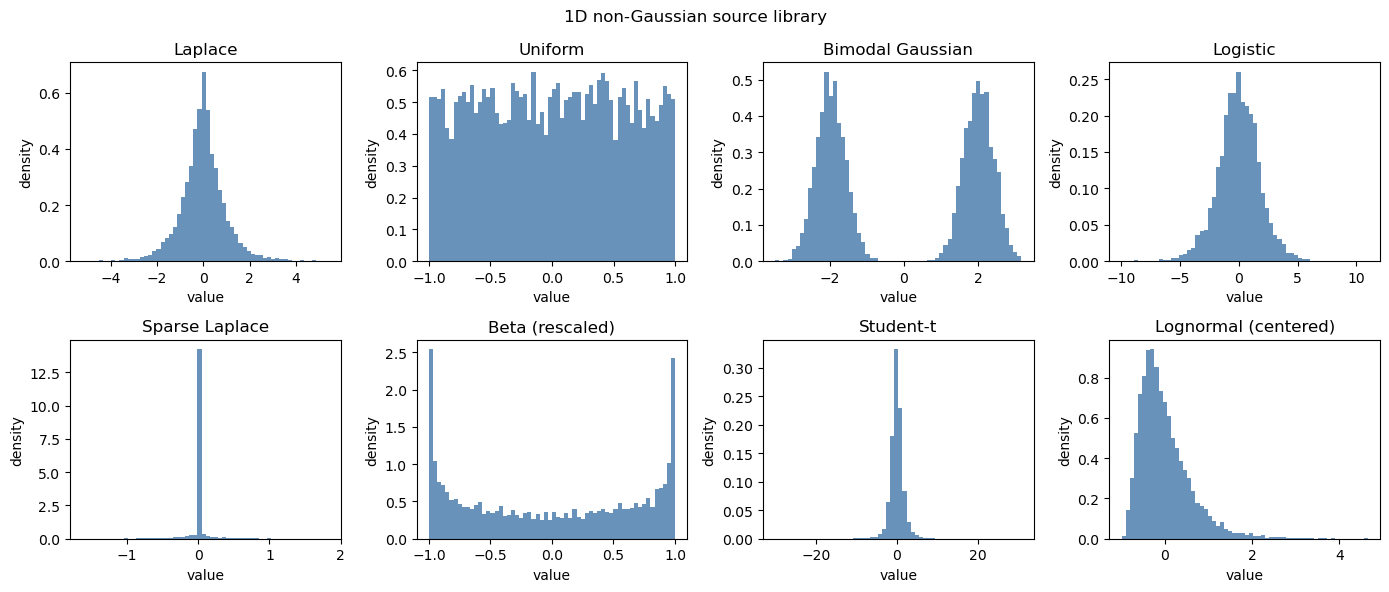

In [3]:
n_samples = 6000
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.ravel()

for ax, (name, sampler) in zip(axes, distribution_catalog.items()):
    data = sampler(n_samples)
    ax.hist(data, bins=60, density=True, alpha=0.8, color="#4477aa")
    ax.set_title(name)
    ax.set_xlabel("value")
    ax.set_ylabel("density")

fig.suptitle("1D non-Gaussian source library")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "1d_distributions.png"), dpi=300, bbox_inches="tight")
plt.show()

## Independent joint distributions

Independent sources simply combine via a Cartesian product of marginals. Even
without “limbs,” the cloud reflects independence because it fills the space
uniformly along both axes.

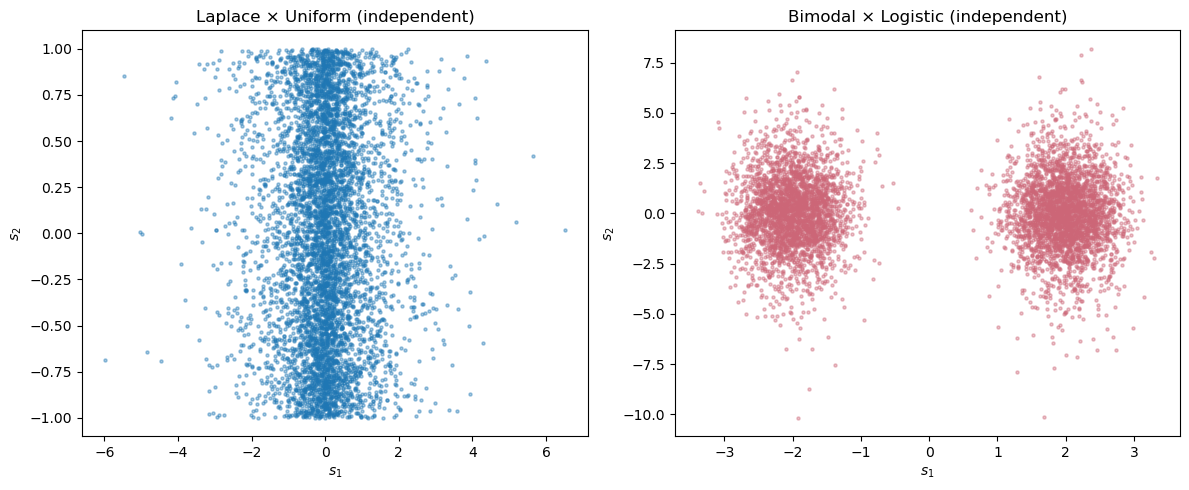

In [4]:
def sample_independent_pair(
    sampler_x: Callable[[int], np.ndarray],
    sampler_y: Callable[[int], np.ndarray],
    size: int,
) -> np.ndarray:
    return np.vstack([sampler_x(size), sampler_y(size)])


pair_a = sample_independent_pair(sample_laplace, sample_uniform, n_samples)
pair_b = sample_independent_pair(sample_bimodal, sample_logistic, n_samples)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(pair_a[0], pair_a[1], s=5, alpha=0.4)
axes[0].set_title("Laplace × Uniform (independent)")
axes[0].set_xlabel("$s_1$")
axes[0].set_ylabel("$s_2$")
axes[1].scatter(pair_b[0], pair_b[1], s=5, alpha=0.4, color="#cc6677")
axes[1].set_title("Bimodal × Logistic (independent)")
axes[1].set_xlabel("$s_1$")
axes[1].set_ylabel("$s_2$")
plt.tight_layout()
plt.savefig(
    os.path.join(FIG_DIR, "independent_pairs.png"), dpi=300, bbox_inches="tight"
)
plt.show()

## Dependent joints via linear mixing

Linear mixing `x = A @ s` creates dependencies between coordinates even though
the latent sources remain independent. ICA assumes this kind of mixing.

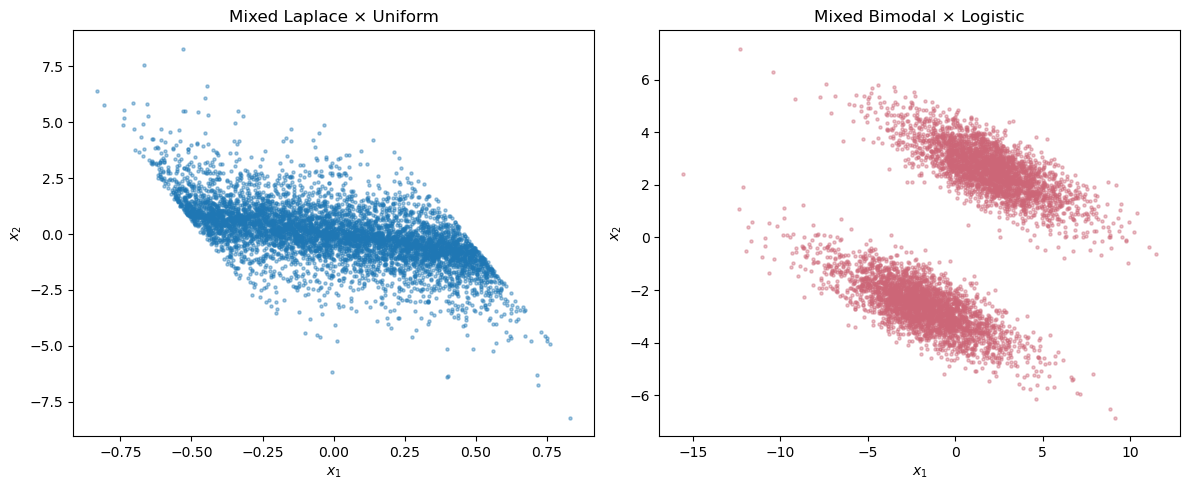

In [5]:
def mix_sources(sources: np.ndarray) -> np.ndarray:
    A = rng.normal(0, 1, size=(2, 2))
    while np.linalg.det(A) == 0:
        A = rng.normal(0, 1, size=(2, 2))
    return A @ sources


mixed_a = mix_sources(pair_a)
mixed_b = mix_sources(pair_b)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(mixed_a[0], mixed_a[1], s=5, alpha=0.4)
axes[0].set_title("Mixed Laplace × Uniform")
axes[0].set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")
axes[1].scatter(mixed_b[0], mixed_b[1], s=5, alpha=0.4, color="#cc6677")
axes[1].set_title("Mixed Bimodal × Logistic")
axes[1].set_xlabel("$x_1$")
axes[1].set_ylabel("$x_2$")
plt.tight_layout()
plt.savefig(
    os.path.join(FIG_DIR, "dependent_linear_mixing.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## Dependent joints via probabilistic mixture

Not all dependencies come from linear mixing. A Gaussian mixture model (GMM)
creates clusters that reflect switching among different regimes.

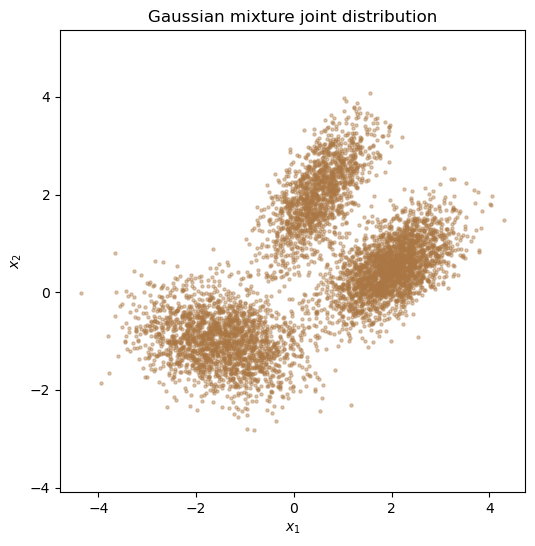

In [6]:
gmm_means = np.array([[2.0, 0.5], [-1.5, -1.0], [0.5, 2.0]])
gmm_covs = np.array(
    [
        [[0.4, 0.2], [0.2, 0.3]],
        [[0.6, -0.1], [-0.1, 0.3]],
        [[0.3, 0.25], [0.25, 0.5]],
    ]
)
weights = np.array([0.4, 0.35, 0.25])

components = rng.choice(len(weights), size=n_samples, p=weights)
samples = np.zeros((2, n_samples))
for k in range(len(weights)):
    idx = components == k
    count = np.sum(idx)
    if count == 0:
        continue
    samples[:, idx] = rng.multivariate_normal(
        gmm_means[k], gmm_covs[k], size=count
    ).T

plt.figure(figsize=(6, 6))
plt.scatter(samples[0], samples[1], s=5, alpha=0.4, color="#aa7744")
plt.title("Gaussian mixture joint distribution")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.savefig(
    os.path.join(FIG_DIR, "dependent_gmm.png"), dpi=300, bbox_inches="tight"
)
plt.show()

## Summary

* Independent joints arise from combinations of independent 1D sources.
* Linear mixing produces dependencies even if the linchpin sources stay
  independent—exactly ICA's generative assumption.
* Probabilistic mixtures introduce dependence via switching, leading to very
  different geometries than linear mixing.